In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import sys
sys.tracebacklimit = 0

import numpy as np
import networkx as nx 
import matplotlib.pyplot as plt

In [3]:
from pettingzoo.test import parallel_api_test
from solution.custom_gym import CustomGymEnviornment
from solution.trainer import *
from solution.policy_net import *

In [4]:
from core.agent import *
from core.world import * 
from core.render import * 
from core.skill import * 
from core.models import *
from core.message import *

In [5]:
from sar.sar_agent import *
from sar.sar_world import *
from sar.sar_env_params import *

belief_initializer = SARBeliefInitializer(BELIEF_DIMS)
def initialize_swarm(world : BaseWorld):
    swarm = [SARAgent() for i in range(SWARM_SIZE)]
    for agent in swarm:
        agent.set_utility(SARUtilityFunction())
        world.add_agent(agent)
    swarm = initialize_positions_randomly(world, swarm)
    swarm = belief_initializer.initialize_beliefs(swarm)

In [6]:

from sar.urban_gen import * 
from sar.victims import * 
from sar.sar_comm import * 

terrain_generator = UrbanTerrainMapGenerator(padding = MAX_VISIBILITY)
victim_generator = VictimGenerator(padding = MAX_VISIBILITY)
def initialize_terrain(world : BaseWorld):
    terrain_map, population_map = terrain_generator.generate(world._dims)
    map_collection : BaseMapCollection = BaseMapCollection()
    map_collection.add_map("Terrain", terrain_map)
    map_collection.add_map("Population", population_map)

    victim_generator.set_density_map(population_map)
    victim_map = victim_generator.generate(world._dims)

    map_collection.add_map("Victims", victim_map)
    return map_collection


In [7]:
from sar.energy import EnergyModel
from sar.victims import VictimModel
from solution.sar_action_interpreter import *
from solution.encoder_net import *
from models.complex_model import * 

world = SARWorld(dims = WORLD_DIMS,
              swarm_initializer= initialize_swarm,
              generation_pipeline=initialize_terrain
              )
world.add_model("energy_model", EnergyModel())
world.add_model("victim_model", VictimModel())
world.reset()

In [8]:
policy_net= PolicyNet(1, 7, 4)
target_net=  PolicyNet(1, 7, 4)
encoder_model = Encoder()
decoder_model = Decoder()

complex_model = ComplexModel(
    policy_net= policy_net, 
    encoder_net = encoder_model, 
    decoder_net = decoder_model
)

comms_protocol = SARCommunicationProtocol(encoder_model, decoder_model)
action_interpreter = SARActionInterpreter(BELIEF_DIMS)

custom_gym : CustomGymEnviornment = CustomGymEnviornment(world, action_interpreter, comms_protocol)

In [9]:
custom_gym.reset(42)

({1: {'Belief': array([0., 0., 0., 0., 0.]),
   'Victims': array([[1., 0., 1., 0., 1., 1., 1.],
          [0., 0., 1., 0., 0., 1., 1.],
          [0., 0., 1., 1., 0., 1., 0.],
          [0., 1., 1., 0., 1., 0., 1.],
          [1., 1., 1., 1., 1., 1., 1.],
          [1., 0., 1., 1., 1., 1., 1.],
          [1., 0., 1., 0., 1., 1., 1.]]),
   'Energy': 100.0},
  2: {'Belief': array([0., 0., 0., 0., 0.]),
   'Victims': array([[0., 1., 1., 1., 0., 1., 1.],
          [0., 0., 0., 1., 1., 1., 0.],
          [1., 0., 1., 0., 0., 1., 0.],
          [0., 1., 0., 0., 0., 1., 1.],
          [1., 0., 1., 0., 0., 1., 0.],
          [0., 0., 1., 1., 0., 1., 1.],
          [0., 0., 0., 1., 0., 1., 0.]]),
   'Energy': 100.0},
  3: {'Belief': array([0., 0., 0., 0., 0.]),
   'Victims': array([[1., 1., 1., 1., 1., 0., 1.],
          [0., 1., 1., 0., 1., 1., 1.],
          [1., 0., 0., 1., 1., 1., 1.],
          [1., 1., 0., 0., 0., 0., 0.],
          [0., 1., 1., 1., 0., 0., 1.],
          [1., 1., 0., 0.,

### Testing

In [10]:
parallel_api_test(custom_gym, num_cycles=1_000)
custom_gym.reset()

Passed Parallel API test


({1: {'Belief': array([0., 0., 0., 0., 0.]),
   'Victims': array([[1., 0., 1., 0., 1., 1., 1.],
          [0., 0., 1., 0., 0., 1., 1.],
          [0., 0., 1., 1., 0., 1., 0.],
          [0., 1., 1., 0., 1., 0., 1.],
          [1., 1., 1., 1., 1., 1., 1.],
          [1., 0., 1., 1., 1., 1., 1.],
          [1., 0., 1., 0., 1., 1., 1.]]),
   'Energy': 100.0},
  2: {'Belief': array([0., 0., 0., 0., 0.]),
   'Victims': array([[0., 1., 1., 1., 0., 1., 1.],
          [0., 0., 0., 1., 1., 1., 0.],
          [1., 0., 1., 0., 0., 1., 0.],
          [0., 1., 0., 0., 0., 1., 1.],
          [1., 0., 1., 0., 0., 1., 0.],
          [0., 0., 1., 1., 0., 1., 1.],
          [0., 0., 0., 1., 0., 1., 0.]]),
   'Energy': 100.0},
  3: {'Belief': array([0., 0., 0., 0., 0.]),
   'Victims': array([[1., 1., 1., 1., 1., 0., 1.],
          [0., 1., 1., 0., 1., 1., 1.],
          [1., 0., 0., 1., 1., 1., 1.],
          [1., 1., 0., 0., 0., 0., 0.],
          [0., 1., 1., 1., 0., 0., 1.],
          [1., 1., 0., 0.,

# Training

In [11]:

from models.base import * 
from models.idqn import * 
from solution.policy_net import PolicyNet
import matplotlib.pyplot as plt

In [12]:
model = IDQN(env = custom_gym,
             feature_extractor= feature_extractor,
             target_net= target_net,
             model= complex_model,
             batch_size=1024,
             device = "cpu"
             )

In [ ]:
rewards = train_loop(custom_gym, model, games=10, optimization_passes = 1, seed=42)

Training on thesis.


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Average loss 9.085134193208068
Model has been saved.

Starting evaluation on thesis (num_games=1)


Training Progress:   2%|▏         | 1/50 [02:28<2:01:08, 148.34s/it]

Avg reward: 308.657  std: 322.0083560266721  coeff : 1.043256287810327
Avg reward per agent, per game:  {1: 0.0, 2: 190.0, 3: 99.0, 4: 460.0, 5: 294.0, 6: 483.0, 7: 1697.0, 8: 296.0, 9: 0.0, 10: 1164.0, 11: 480.0, 12: 196.0, 13: 478.0, 14: 0.0, 15: 285.0, 16: 0.0, 17: 96.0, 18: 0.0, 19: 0.0, 20: 196.0, 21: 99.0, 22: 0.0, 23: 565.0, 24: 289.0, 25: 475.0, 26: 1379.0, 27: 294.0, 28: 198.0, 29: 0.0, 30: 1007.0, 31: 294.0, 32: 197.0, 33: 99.0, 34: 1105.0, 35: 380.0, 36: 393.0, 37: 1090.0, 38: 1698.0, 39: 99.0, 40: 385.0, 41: 295.0, 42: 665.0, 43: 674.0, 44: 191.0, 45: 198.0, 46: 0.0, 47: 0.0, 48: 741.0, 49: 193.0, 50: 99.0, 51: 197.0, 52: 97.0, 53: 583.0, 54: 186.0, 55: 383.0, 56: 99.0, 57: 98.0, 58: 197.0, 59: 197.0, 60: 485.0, 61: 197.0, 62: 484.0, 63: 565.0, 64: 295.0, 65: 393.0, 66: 99.0, 67: 196.0, 68: 387.0, 69: 390.0, 70: 99.0, 71: 652.0, 72: 99.0, 73: 958.0, 74: 570.0, 75: 853.0, 76: 576.0, 77: 99.0, 78: 195.0, 79: 0.0, 80: 0.0, 81: 291.0, 82: 387.0, 83: 387.0, 84: 841.0, 85: 99.0, 

Training Progress:   4%|▍         | 2/50 [05:19<2:09:18, 161.64s/it]

Avg reward: 312.931  std: 321.5755249377664  coeff : 1.027624380255604
Avg reward per agent, per game:  {1: 0.0, 2: 190.0, 3: 99.0, 4: 460.0, 5: 294.0, 6: 483.0, 7: 1697.0, 8: 296.0, 9: 0.0, 10: 1164.0, 11: 480.0, 12: 196.0, 13: 478.0, 14: 0.0, 15: 285.0, 16: 0.0, 17: 96.0, 18: 0.0, 19: 0.0, 20: 196.0, 21: 99.0, 22: 0.0, 23: 565.0, 24: 289.0, 25: 475.0, 26: 1379.0, 27: 294.0, 28: 198.0, 29: 0.0, 30: 1007.0, 31: 294.0, 32: 197.0, 33: 99.0, 34: 1105.0, 35: 380.0, 36: 393.0, 37: 1090.0, 38: 579.0, 39: 99.0, 40: 385.0, 41: 295.0, 42: 665.0, 43: 674.0, 44: 191.0, 45: 198.0, 46: 0.0, 47: 0.0, 48: 741.0, 49: 193.0, 50: 99.0, 51: 197.0, 52: 97.0, 53: 583.0, 54: 186.0, 55: 383.0, 56: 99.0, 57: 98.0, 58: 197.0, 59: 197.0, 60: 485.0, 61: 197.0, 62: 484.0, 63: 565.0, 64: 295.0, 65: 393.0, 66: 99.0, 67: 196.0, 68: 387.0, 69: 390.0, 70: 99.0, 71: 652.0, 72: 99.0, 73: 958.0, 74: 570.0, 75: 853.0, 76: 576.0, 77: 99.0, 78: 195.0, 79: 0.0, 80: 0.0, 81: 291.0, 82: 387.0, 83: 387.0, 84: 841.0, 85: 99.0, 8

Training Progress:   6%|▌         | 3/50 [08:14<2:11:26, 167.81s/it]

Avg reward: 415.825  std: 277.95345361229096  coeff : 0.6684385345092069
Avg reward per agent, per game:  {1: 286.0, 2: 658.0, 3: 938.0, 4: 480.0, 5: 99.0, 6: 473.0, 7: 487.0, 8: 296.0, 9: 663.0, 10: 766.0, 11: 650.0, 12: 476.0, 13: 752.0, 14: 186.0, 15: 383.0, 16: 780.0, 17: 99.0, 18: 0.0, 19: 737.0, 20: 296.0, 21: 99.0, 22: 98.0, 23: 475.0, 24: 480.0, 25: 196.0, 26: 847.0, 27: 568.0, 28: 295.0, 29: 0.0, 30: 577.0, 31: 569.0, 32: 765.0, 33: 475.0, 34: 756.0, 35: 757.0, 36: 393.0, 37: 654.0, 38: 945.0, 39: 566.0, 40: 764.0, 41: 1023.0, 42: 752.0, 43: 1035.0, 44: 573.0, 45: 198.0, 46: 0.0, 47: 388.0, 48: 268.0, 49: 190.0, 50: 732.0, 51: 197.0, 52: 97.0, 53: 653.0, 54: 98.0, 55: 292.0, 56: 290.0, 57: 384.0, 58: 387.0, 59: 197.0, 60: 1032.0, 61: 294.0, 62: 390.0, 63: 393.0, 64: 194.0, 65: 486.0, 66: 198.0, 67: 294.0, 68: 295.0, 69: 581.0, 70: 473.0, 71: 847.0, 72: 198.0, 73: 1123.0, 74: 198.0, 75: 941.0, 76: 197.0, 77: 610.0, 78: 99.0, 79: 90.0, 80: 0.0, 81: 197.0, 82: 760.0, 83: 929.0, 8

Training Progress:   8%|▊         | 4/50 [10:47<2:04:11, 161.98s/it]

Avg reward: 419.971  std: 284.46293635375423  coeff : 0.6773394742821629
Avg reward per agent, per game:  {1: 98.0, 2: 475.0, 3: 296.0, 4: 1017.0, 5: 99.0, 6: 579.0, 7: 488.0, 8: 296.0, 9: 930.0, 10: 487.0, 11: 462.0, 12: 481.0, 13: 579.0, 14: 96.0, 15: 384.0, 16: 477.0, 17: 99.0, 18: 0.0, 19: 843.0, 20: 295.0, 21: 283.0, 22: 98.0, 23: 655.0, 24: 666.0, 25: 292.0, 26: 1295.0, 27: 478.0, 28: 198.0, 29: 91.0, 30: 672.0, 31: 755.0, 32: 678.0, 33: 489.0, 34: 580.0, 35: 579.0, 36: 393.0, 37: 663.0, 38: 1099.0, 39: 1172.0, 40: 285.0, 41: 295.0, 42: 760.0, 43: 487.0, 44: 294.0, 45: 198.0, 46: 0.0, 47: 294.0, 48: 99.0, 49: 99.0, 50: 196.0, 51: 197.0, 52: 294.0, 53: 753.0, 54: 98.0, 55: 579.0, 56: 483.0, 57: 748.0, 58: 197.0, 59: 197.0, 60: 771.0, 61: 481.0, 62: 489.0, 63: 296.0, 64: 99.0, 65: 1044.0, 66: 198.0, 67: 294.0, 68: 482.0, 69: 759.0, 70: 287.0, 71: 852.0, 72: 198.0, 73: 96.0, 74: 198.0, 75: 863.0, 76: 99.0, 77: 296.0, 78: 99.0, 79: 0.0, 80: 194.0, 81: 194.0, 82: 669.0, 83: 938.0, 84:

Training Progress:  10%|█         | 5/50 [13:48<2:06:43, 168.97s/it]

Avg reward: 423.64  std: 288.8649102954528  coeff : 0.6818641070140987
Avg reward per agent, per game:  {1: 95.0, 2: 1087.0, 3: 485.0, 4: 578.0, 5: 185.0, 6: 749.0, 7: 488.0, 8: 296.0, 9: 453.0, 10: 678.0, 11: 288.0, 12: 486.0, 13: 486.0, 14: 95.0, 15: 384.0, 16: 356.0, 17: 190.0, 18: 0.0, 19: 567.0, 20: 295.0, 21: 99.0, 22: 240.0, 23: 565.0, 24: 196.0, 25: 99.0, 26: 855.0, 27: 470.0, 28: 198.0, 29: 0.0, 30: 479.0, 31: 579.0, 32: 764.0, 33: 292.0, 34: 927.0, 35: 668.0, 36: 393.0, 37: 290.0, 38: 762.0, 39: 656.0, 40: 1009.0, 41: 295.0, 42: 664.0, 43: 753.0, 44: 294.0, 45: 198.0, 46: 0.0, 47: 294.0, 48: 456.0, 49: 287.0, 50: 195.0, 51: 197.0, 52: 97.0, 53: 487.0, 54: 193.0, 55: 197.0, 56: 294.0, 57: 574.0, 58: 753.0, 59: 197.0, 60: 674.0, 61: 386.0, 62: 295.0, 63: 470.0, 64: 259.0, 65: 486.0, 66: 187.0, 67: 294.0, 68: 388.0, 69: 954.0, 70: 554.0, 71: 754.0, 72: 557.0, 73: 439.0, 74: 198.0, 75: 1093.0, 76: 284.0, 77: 581.0, 78: 282.0, 79: 0.0, 80: 480.0, 81: 98.0, 82: 294.0, 83: 483.0, 84

Training Progress:  12%|█▏        | 6/50 [16:32<2:02:31, 167.09s/it]

Avg reward: 417.837  std: 292.91509423551395  coeff : 0.7010271810191868
Avg reward per agent, per game:  {1: 0.0, 2: 288.0, 3: 99.0, 4: 758.0, 5: 99.0, 6: 570.0, 7: 470.0, 8: 296.0, 9: 197.0, 10: 763.0, 11: 198.0, 12: 389.0, 13: 665.0, 14: 89.0, 15: 660.0, 16: 95.0, 17: 292.0, 18: 0.0, 19: 366.0, 20: 198.0, 21: 99.0, 22: 98.0, 23: 658.0, 24: 291.0, 25: 188.0, 26: 469.0, 27: 393.0, 28: 198.0, 29: 0.0, 30: 764.0, 31: 840.0, 32: 1040.0, 33: 389.0, 34: 945.0, 35: 668.0, 36: 393.0, 37: 194.0, 38: 294.0, 39: 761.0, 40: 671.0, 41: 295.0, 42: 577.0, 43: 854.0, 44: 382.0, 45: 584.0, 46: 190.0, 47: 294.0, 48: 274.0, 49: 286.0, 50: 196.0, 51: 197.0, 52: 294.0, 53: 296.0, 54: 98.0, 55: 922.0, 56: 771.0, 57: 660.0, 58: 663.0, 59: 197.0, 60: 581.0, 61: 294.0, 62: 295.0, 63: 295.0, 64: 295.0, 65: 296.0, 66: 198.0, 67: 294.0, 68: 295.0, 69: 668.0, 70: 463.0, 71: 1112.0, 72: 485.0, 73: 96.0, 74: 198.0, 75: 1221.0, 76: 833.0, 77: 666.0, 78: 99.0, 79: 0.0, 80: 480.0, 81: 98.0, 82: 377.0, 83: 484.0, 84: 

Training Progress:  14%|█▍        | 7/50 [19:32<2:02:52, 171.44s/it]

Avg reward: 416.567  std: 285.8094356577473  coeff : 0.6861067623161395
Avg reward per agent, per game:  {1: 289.0, 2: 656.0, 3: 99.0, 4: 578.0, 5: 99.0, 6: 478.0, 7: 581.0, 8: 296.0, 9: 197.0, 10: 856.0, 11: 198.0, 12: 903.0, 13: 487.0, 14: 192.0, 15: 287.0, 16: 99.0, 17: 386.0, 18: 0.0, 19: 290.0, 20: 198.0, 21: 99.0, 22: 97.0, 23: 0.0, 24: 291.0, 25: 196.0, 26: 738.0, 27: 483.0, 28: 198.0, 29: 0.0, 30: 579.0, 31: 294.0, 32: 674.0, 33: 296.0, 34: 1030.0, 35: 578.0, 36: 677.0, 37: 197.0, 38: 942.0, 39: 842.0, 40: 290.0, 41: 295.0, 42: 485.0, 43: 584.0, 44: 473.0, 45: 483.0, 46: 285.0, 47: 294.0, 48: 187.0, 49: 286.0, 50: 559.0, 51: 483.0, 52: 294.0, 53: 771.0, 54: 282.0, 55: 197.0, 56: 580.0, 57: 660.0, 58: 849.0, 59: 197.0, 60: 855.0, 61: 485.0, 62: 294.0, 63: 295.0, 64: 295.0, 65: 296.0, 66: 384.0, 67: 388.0, 68: 753.0, 69: 483.0, 70: 287.0, 71: 576.0, 72: 391.0, 73: 97.0, 74: 198.0, 75: 678.0, 76: 197.0, 77: 578.0, 78: 99.0, 79: 0.0, 80: 291.0, 81: 294.0, 82: 836.0, 83: 197.0, 84: 

Training Progress:  16%|█▌        | 8/50 [22:31<2:01:34, 173.69s/it]

Avg reward: 416.964  std: 284.2288526944441  coeff : 0.6816628118841053
Avg reward per agent, per game:  {1: 289.0, 2: 389.0, 3: 485.0, 4: 485.0, 5: 99.0, 6: 579.0, 7: 581.0, 8: 296.0, 9: 937.0, 10: 954.0, 11: 198.0, 12: 387.0, 13: 487.0, 14: 192.0, 15: 193.0, 16: 190.0, 17: 196.0, 18: 0.0, 19: 376.0, 20: 198.0, 21: 99.0, 22: 98.0, 23: 270.0, 24: 478.0, 25: 196.0, 26: 484.0, 27: 581.0, 28: 198.0, 29: 0.0, 30: 945.0, 31: 388.0, 32: 671.0, 33: 489.0, 34: 1034.0, 35: 579.0, 36: 860.0, 37: 197.0, 38: 945.0, 39: 760.0, 40: 287.0, 41: 295.0, 42: 485.0, 43: 952.0, 44: 197.0, 45: 198.0, 46: 288.0, 47: 294.0, 48: 180.0, 49: 286.0, 50: 476.0, 51: 668.0, 52: 389.0, 53: 862.0, 54: 193.0, 55: 197.0, 56: 763.0, 57: 386.0, 58: 765.0, 59: 293.0, 60: 851.0, 61: 485.0, 62: 294.0, 63: 388.0, 64: 584.0, 65: 393.0, 66: 292.0, 67: 388.0, 68: 574.0, 69: 1377.0, 70: 287.0, 71: 764.0, 72: 668.0, 73: 95.0, 74: 288.0, 75: 584.0, 76: 197.0, 77: 668.0, 78: 190.0, 79: 0.0, 80: 291.0, 81: 390.0, 82: 1076.0, 83: 197.

Training Progress:  18%|█▊        | 9/50 [25:28<1:59:32, 174.95s/it]

Avg reward: 420.511  std: 283.67684410081836  coeff : 0.674600293692242
Avg reward per agent, per game:  {1: 289.0, 2: 483.0, 3: 489.0, 4: 485.0, 5: 99.0, 6: 486.0, 7: 488.0, 8: 296.0, 9: 927.0, 10: 954.0, 11: 198.0, 12: 294.0, 13: 392.0, 14: 89.0, 15: 193.0, 16: 290.0, 17: 287.0, 18: 0.0, 19: 931.0, 20: 198.0, 21: 285.0, 22: 98.0, 23: 0.0, 24: 569.0, 25: 196.0, 26: 485.0, 27: 393.0, 28: 198.0, 29: 0.0, 30: 1033.0, 31: 575.0, 32: 671.0, 33: 489.0, 34: 1034.0, 35: 671.0, 36: 678.0, 37: 197.0, 38: 935.0, 39: 760.0, 40: 563.0, 41: 393.0, 42: 484.0, 43: 676.0, 44: 285.0, 45: 288.0, 46: 0.0, 47: 388.0, 48: 99.0, 49: 291.0, 50: 385.0, 51: 668.0, 52: 389.0, 53: 1039.0, 54: 98.0, 55: 197.0, 56: 674.0, 57: 288.0, 58: 579.0, 59: 293.0, 60: 1289.0, 61: 485.0, 62: 489.0, 63: 296.0, 64: 584.0, 65: 393.0, 66: 198.0, 67: 294.0, 68: 661.0, 69: 1034.0, 70: 287.0, 71: 660.0, 72: 848.0, 73: 96.0, 74: 198.0, 75: 584.0, 76: 197.0, 77: 661.0, 78: 99.0, 79: 0.0, 80: 291.0, 81: 390.0, 82: 931.0, 83: 279.0, 84

Training Progress:  20%|██        | 10/50 [28:25<1:56:56, 175.41s/it]

Avg reward: 415.135  std: 279.3662591921222  coeff : 0.6729527965411787
Avg reward per agent, per game:  {1: 289.0, 2: 574.0, 3: 489.0, 4: 578.0, 5: 99.0, 6: 761.0, 7: 488.0, 8: 296.0, 9: 920.0, 10: 952.0, 11: 387.0, 12: 386.0, 13: 487.0, 14: 97.0, 15: 193.0, 16: 196.0, 17: 191.0, 18: 0.0, 19: 479.0, 20: 295.0, 21: 283.0, 22: 98.0, 23: 0.0, 24: 569.0, 25: 196.0, 26: 672.0, 27: 393.0, 28: 198.0, 29: 0.0, 30: 1034.0, 31: 845.0, 32: 850.0, 33: 489.0, 34: 1034.0, 35: 842.0, 36: 678.0, 37: 197.0, 38: 672.0, 39: 849.0, 40: 557.0, 41: 393.0, 42: 482.0, 43: 676.0, 44: 197.0, 45: 292.0, 46: 0.0, 47: 553.0, 48: 99.0, 49: 291.0, 50: 473.0, 51: 483.0, 52: 294.0, 53: 863.0, 54: 282.0, 55: 197.0, 56: 674.0, 57: 290.0, 58: 851.0, 59: 565.0, 60: 846.0, 61: 485.0, 62: 580.0, 63: 391.0, 64: 584.0, 65: 393.0, 66: 198.0, 67: 484.0, 68: 295.0, 69: 939.0, 70: 287.0, 71: 570.0, 72: 582.0, 73: 0.0, 74: 198.0, 75: 677.0, 76: 197.0, 77: 485.0, 78: 274.0, 79: 0.0, 80: 291.0, 81: 390.0, 82: 754.0, 83: 569.0, 84: 

Training Progress:  22%|██▏       | 11/50 [31:26<1:55:04, 177.05s/it]

Avg reward: 417.351  std: 277.8058095126882  coeff : 0.6656406945537167
Avg reward per agent, per game:  {1: 289.0, 2: 483.0, 3: 678.0, 4: 485.0, 5: 99.0, 6: 666.0, 7: 488.0, 8: 296.0, 9: 290.0, 10: 1098.0, 11: 478.0, 12: 486.0, 13: 392.0, 14: 89.0, 15: 99.0, 16: 196.0, 17: 196.0, 18: 0.0, 19: 754.0, 20: 482.0, 21: 99.0, 22: 98.0, 23: 188.0, 24: 569.0, 25: 196.0, 26: 197.0, 27: 393.0, 28: 198.0, 29: 0.0, 30: 1209.0, 31: 848.0, 32: 666.0, 33: 489.0, 34: 764.0, 35: 671.0, 36: 771.0, 37: 292.0, 38: 1361.0, 39: 849.0, 40: 195.0, 41: 393.0, 42: 1006.0, 43: 677.0, 44: 290.0, 45: 483.0, 46: 0.0, 47: 0.0, 48: 177.0, 49: 824.0, 50: 196.0, 51: 483.0, 52: 294.0, 53: 672.0, 54: 282.0, 55: 197.0, 56: 674.0, 57: 290.0, 58: 579.0, 59: 197.0, 60: 972.0, 61: 485.0, 62: 489.0, 63: 295.0, 64: 677.0, 65: 296.0, 66: 198.0, 67: 294.0, 68: 388.0, 69: 954.0, 70: 99.0, 71: 1363.0, 72: 570.0, 73: 95.0, 74: 463.0, 75: 767.0, 76: 197.0, 77: 668.0, 78: 1039.0, 79: 0.0, 80: 531.0, 81: 579.0, 82: 1102.0, 83: 1122.0,

Training Progress:  24%|██▍       | 12/50 [34:22<1:52:03, 176.94s/it]

Avg reward: 417.092  std: 279.8424048209992  coeff : 0.6709368792041066
Avg reward per agent, per game:  {1: 289.0, 2: 483.0, 3: 489.0, 4: 485.0, 5: 99.0, 6: 662.0, 7: 393.0, 8: 296.0, 9: 286.0, 10: 1276.0, 11: 1122.0, 12: 486.0, 13: 392.0, 14: 0.0, 15: 99.0, 16: 196.0, 17: 382.0, 18: 0.0, 19: 294.0, 20: 294.0, 21: 99.0, 22: 98.0, 23: 97.0, 24: 197.0, 25: 196.0, 26: 293.0, 27: 393.0, 28: 198.0, 29: 0.0, 30: 1034.0, 31: 757.0, 32: 666.0, 33: 296.0, 34: 954.0, 35: 671.0, 36: 943.0, 37: 485.0, 38: 942.0, 39: 849.0, 40: 290.0, 41: 771.0, 42: 485.0, 43: 584.0, 44: 287.0, 45: 198.0, 46: 0.0, 47: 0.0, 48: 420.0, 49: 824.0, 50: 385.0, 51: 576.0, 52: 294.0, 53: 568.0, 54: 282.0, 55: 482.0, 56: 674.0, 57: 385.0, 58: 763.0, 59: 197.0, 60: 582.0, 61: 471.0, 62: 580.0, 63: 295.0, 64: 393.0, 65: 393.0, 66: 99.0, 67: 484.0, 68: 295.0, 69: 1375.0, 70: 99.0, 71: 672.0, 72: 476.0, 73: 0.0, 74: 463.0, 75: 767.0, 76: 197.0, 77: 668.0, 78: 282.0, 79: 0.0, 80: 555.0, 81: 197.0, 82: 665.0, 83: 757.0, 84: 294

Training Progress:  26%|██▌       | 13/50 [37:18<1:48:47, 176.42s/it]

Avg reward: 418.857  std: 279.7251875519972  coeff : 0.6678298024194347
Avg reward per agent, per game:  {1: 0.0, 2: 1000.0, 3: 489.0, 4: 664.0, 5: 99.0, 6: 748.0, 7: 467.0, 8: 296.0, 9: 285.0, 10: 843.0, 11: 472.0, 12: 389.0, 13: 487.0, 14: 271.0, 15: 184.0, 16: 196.0, 17: 289.0, 18: 0.0, 19: 785.0, 20: 388.0, 21: 99.0, 22: 98.0, 23: 196.0, 24: 197.0, 25: 99.0, 26: 751.0, 27: 393.0, 28: 488.0, 29: 0.0, 30: 385.0, 31: 1193.0, 32: 840.0, 33: 296.0, 34: 1044.0, 35: 671.0, 36: 1090.0, 37: 576.0, 38: 1205.0, 39: 99.0, 40: 552.0, 41: 584.0, 42: 574.0, 43: 584.0, 44: 197.0, 45: 198.0, 46: 385.0, 47: 0.0, 48: 533.0, 49: 567.0, 50: 625.0, 51: 481.0, 52: 294.0, 53: 751.0, 54: 282.0, 55: 461.0, 56: 764.0, 57: 840.0, 58: 671.0, 59: 197.0, 60: 1294.0, 61: 294.0, 62: 393.0, 63: 296.0, 64: 549.0, 65: 393.0, 66: 99.0, 67: 484.0, 68: 389.0, 69: 1130.0, 70: 378.0, 71: 753.0, 72: 99.0, 73: 0.0, 74: 198.0, 75: 763.0, 76: 197.0, 77: 579.0, 78: 282.0, 79: 0.0, 80: 197.0, 81: 197.0, 82: 665.0, 83: 734.0, 84

Training Progress:  28%|██▊       | 14/50 [40:20<1:46:56, 178.23s/it]

Avg reward: 412.736  std: 280.4641123281194  coeff : 0.6795242293575541
Avg reward per agent, per game:  {1: 85.0, 2: 664.0, 3: 745.0, 4: 572.0, 5: 99.0, 6: 576.0, 7: 393.0, 8: 296.0, 9: 380.0, 10: 1086.0, 11: 389.0, 12: 388.0, 13: 487.0, 14: 190.0, 15: 186.0, 16: 196.0, 17: 379.0, 18: 0.0, 19: 757.0, 20: 485.0, 21: 196.0, 22: 183.0, 23: 0.0, 24: 197.0, 25: 99.0, 26: 1278.0, 27: 393.0, 28: 295.0, 29: 0.0, 30: 294.0, 31: 849.0, 32: 669.0, 33: 674.0, 34: 1036.0, 35: 758.0, 36: 1038.0, 37: 646.0, 38: 1208.0, 39: 849.0, 40: 579.0, 41: 393.0, 42: 485.0, 43: 584.0, 44: 290.0, 45: 198.0, 46: 98.0, 47: 0.0, 48: 99.0, 49: 567.0, 50: 196.0, 51: 482.0, 52: 294.0, 53: 1122.0, 54: 98.0, 55: 197.0, 56: 1378.0, 57: 283.0, 58: 854.0, 59: 197.0, 60: 947.0, 61: 388.0, 62: 489.0, 63: 553.0, 64: 193.0, 65: 393.0, 66: 99.0, 67: 484.0, 68: 389.0, 69: 1044.0, 70: 465.0, 71: 672.0, 72: 99.0, 73: 462.0, 74: 198.0, 75: 863.0, 76: 473.0, 77: 576.0, 78: 911.0, 79: 0.0, 80: 480.0, 81: 468.0, 82: 754.0, 83: 842.0, 

Training Progress:  30%|███       | 15/50 [43:06<1:41:48, 174.53s/it]

Avg reward: 411.773  std: 278.2416817642533  coeff : 0.6757161877156912
Avg reward per agent, per game:  {1: 0.0, 2: 439.0, 3: 489.0, 4: 485.0, 5: 99.0, 6: 922.0, 7: 393.0, 8: 296.0, 9: 290.0, 10: 672.0, 11: 664.0, 12: 388.0, 13: 571.0, 14: 190.0, 15: 286.0, 16: 196.0, 17: 379.0, 18: 0.0, 19: 576.0, 20: 578.0, 21: 99.0, 22: 98.0, 23: 0.0, 24: 197.0, 25: 99.0, 26: 840.0, 27: 393.0, 28: 488.0, 29: 0.0, 30: 564.0, 31: 849.0, 32: 670.0, 33: 487.0, 34: 1032.0, 35: 577.0, 36: 948.0, 37: 386.0, 38: 840.0, 39: 457.0, 40: 579.0, 41: 1042.0, 42: 576.0, 43: 771.0, 44: 197.0, 45: 198.0, 46: 287.0, 47: 0.0, 48: 99.0, 49: 384.0, 50: 553.0, 51: 480.0, 52: 383.0, 53: 852.0, 54: 98.0, 55: 197.0, 56: 859.0, 57: 193.0, 58: 673.0, 59: 195.0, 60: 578.0, 61: 294.0, 62: 579.0, 63: 296.0, 64: 274.0, 65: 1044.0, 66: 99.0, 67: 390.0, 68: 387.0, 69: 949.0, 70: 378.0, 71: 280.0, 72: 99.0, 73: 463.0, 74: 198.0, 75: 771.0, 76: 197.0, 77: 849.0, 78: 825.0, 79: 0.0, 80: 480.0, 81: 570.0, 82: 987.0, 83: 485.0, 84: 198

Training Progress:  32%|███▏      | 16/50 [45:41<1:35:39, 168.81s/it]

Avg reward: 413.581  std: 278.57525273972203  coeff : 0.6735687875886998
Avg reward per agent, per game:  {1: 98.0, 2: 479.0, 3: 489.0, 4: 485.0, 5: 99.0, 6: 1158.0, 7: 387.0, 8: 296.0, 9: 290.0, 10: 1024.0, 11: 759.0, 12: 476.0, 13: 661.0, 14: 190.0, 15: 278.0, 16: 643.0, 17: 289.0, 18: 97.0, 19: 734.0, 20: 484.0, 21: 99.0, 22: 98.0, 23: 0.0, 24: 562.0, 25: 99.0, 26: 485.0, 27: 393.0, 28: 295.0, 29: 0.0, 30: 571.0, 31: 672.0, 32: 937.0, 33: 670.0, 34: 1215.0, 35: 578.0, 36: 1118.0, 37: 561.0, 38: 1185.0, 39: 284.0, 40: 579.0, 41: 1120.0, 42: 666.0, 43: 771.0, 44: 197.0, 45: 198.0, 46: 98.0, 47: 0.0, 48: 183.0, 49: 565.0, 50: 565.0, 51: 478.0, 52: 383.0, 53: 1221.0, 54: 98.0, 55: 752.0, 56: 859.0, 57: 196.0, 58: 843.0, 59: 283.0, 60: 488.0, 61: 564.0, 62: 489.0, 63: 296.0, 64: 975.0, 65: 1044.0, 66: 99.0, 67: 99.0, 68: 477.0, 69: 571.0, 70: 291.0, 71: 196.0, 72: 99.0, 73: 560.0, 74: 198.0, 75: 393.0, 76: 384.0, 77: 666.0, 78: 288.0, 79: 0.0, 80: 379.0, 81: 661.0, 82: 657.0, 83: 568.0, 

Training Progress:  34%|███▍      | 17/50 [48:44<1:35:09, 173.00s/it]

Avg reward: 408.977  std: 273.2908752062534  coeff : 0.6682304266651998
Avg reward per agent, per game:  {1: 526.0, 2: 558.0, 3: 489.0, 4: 576.0, 5: 99.0, 6: 834.0, 7: 387.0, 8: 296.0, 9: 286.0, 10: 574.0, 11: 457.0, 12: 386.0, 13: 487.0, 14: 0.0, 15: 374.0, 16: 196.0, 17: 375.0, 18: 97.0, 19: 481.0, 20: 389.0, 21: 197.0, 22: 548.0, 23: 196.0, 24: 196.0, 25: 99.0, 26: 483.0, 27: 393.0, 28: 383.0, 29: 0.0, 30: 1184.0, 31: 672.0, 32: 759.0, 33: 391.0, 34: 1387.0, 35: 808.0, 36: 863.0, 37: 483.0, 38: 744.0, 39: 804.0, 40: 764.0, 41: 769.0, 42: 577.0, 43: 584.0, 44: 381.0, 45: 198.0, 46: 359.0, 47: 0.0, 48: 99.0, 49: 291.0, 50: 562.0, 51: 573.0, 52: 294.0, 53: 917.0, 54: 98.0, 55: 658.0, 56: 768.0, 57: 196.0, 58: 487.0, 59: 195.0, 60: 580.0, 61: 565.0, 62: 833.0, 63: 296.0, 64: 99.0, 65: 1032.0, 66: 99.0, 67: 99.0, 68: 484.0, 69: 582.0, 70: 99.0, 71: 463.0, 72: 99.0, 73: 472.0, 74: 198.0, 75: 393.0, 76: 378.0, 77: 483.0, 78: 558.0, 79: 0.0, 80: 99.0, 81: 574.0, 82: 284.0, 83: 1007.0, 84: 3

Training Progress:  36%|███▌      | 18/50 [51:09<1:27:44, 164.53s/it]

Avg reward: 392.054  std: 261.9889827530921  coeff : 0.6682471872576026
Avg reward per agent, per game:  {1: 0.0, 2: 729.0, 3: 489.0, 4: 670.0, 5: 99.0, 6: 478.0, 7: 584.0, 8: 296.0, 9: 288.0, 10: 1033.0, 11: 277.0, 12: 387.0, 13: 487.0, 14: 190.0, 15: 286.0, 16: 99.0, 17: 289.0, 18: 193.0, 19: 567.0, 20: 296.0, 21: 197.0, 22: 98.0, 23: 196.0, 24: 196.0, 25: 99.0, 26: 1018.0, 27: 393.0, 28: 295.0, 29: 0.0, 30: 569.0, 31: 853.0, 32: 748.0, 33: 598.0, 34: 1219.0, 35: 488.0, 36: 1550.0, 37: 294.0, 38: 938.0, 39: 274.0, 40: 654.0, 41: 676.0, 42: 485.0, 43: 771.0, 44: 288.0, 45: 198.0, 46: 0.0, 47: 285.0, 48: 99.0, 49: 383.0, 50: 379.0, 51: 481.0, 52: 294.0, 53: 999.0, 54: 98.0, 55: 1008.0, 56: 855.0, 57: 196.0, 58: 582.0, 59: 282.0, 60: 489.0, 61: 386.0, 62: 579.0, 63: 296.0, 64: 99.0, 65: 579.0, 66: 99.0, 67: 99.0, 68: 484.0, 69: 1279.0, 70: 99.0, 71: 627.0, 72: 99.0, 73: 287.0, 74: 198.0, 75: 393.0, 76: 197.0, 77: 487.0, 78: 288.0, 79: 0.0, 80: 195.0, 81: 290.0, 82: 1028.0, 83: 759.0, 84

Training Progress:  38%|███▊      | 19/50 [54:19<1:28:54, 172.08s/it]

Avg reward: 401.915  std: 269.62763540668453  coeff : 0.6708573589109252
Avg reward per agent, per game:  {1: 80.0, 2: 578.0, 3: 489.0, 4: 670.0, 5: 198.0, 6: 564.0, 7: 768.0, 8: 296.0, 9: 382.0, 10: 1221.0, 11: 198.0, 12: 392.0, 13: 296.0, 14: 347.0, 15: 286.0, 16: 99.0, 17: 289.0, 18: 98.0, 19: 650.0, 20: 732.0, 21: 197.0, 22: 0.0, 23: 99.0, 24: 99.0, 25: 99.0, 26: 1208.0, 27: 393.0, 28: 627.0, 29: 0.0, 30: 936.0, 31: 855.0, 32: 483.0, 33: 580.0, 34: 676.0, 35: 387.0, 36: 859.0, 37: 197.0, 38: 649.0, 39: 99.0, 40: 197.0, 41: 954.0, 42: 485.0, 43: 677.0, 44: 197.0, 45: 486.0, 46: 0.0, 47: 0.0, 48: 99.0, 49: 383.0, 50: 196.0, 51: 390.0, 52: 294.0, 53: 488.0, 54: 98.0, 55: 197.0, 56: 475.0, 57: 374.0, 58: 582.0, 59: 195.0, 60: 582.0, 61: 565.0, 62: 667.0, 63: 296.0, 64: 194.0, 65: 584.0, 66: 99.0, 67: 193.0, 68: 484.0, 69: 1029.0, 70: 99.0, 71: 374.0, 72: 99.0, 73: 288.0, 74: 290.0, 75: 393.0, 76: 272.0, 77: 578.0, 78: 99.0, 79: 98.0, 80: 195.0, 81: 284.0, 82: 704.0, 83: 1277.0, 84: 294

Training Progress:  40%|████      | 20/50 [57:27<1:28:32, 177.08s/it]

Avg reward: 396.0  std: 266.52482435975827  coeff : 0.6730424857569653
Avg reward per agent, per game:  {1: 0.0, 2: 755.0, 3: 575.0, 4: 669.0, 5: 483.0, 6: 474.0, 7: 198.0, 8: 296.0, 9: 290.0, 10: 758.0, 11: 378.0, 12: 481.0, 13: 579.0, 14: 191.0, 15: 361.0, 16: 99.0, 17: 99.0, 18: 98.0, 19: 654.0, 20: 284.0, 21: 197.0, 22: 0.0, 23: 99.0, 24: 383.0, 25: 187.0, 26: 1122.0, 27: 393.0, 28: 478.0, 29: 92.0, 30: 760.0, 31: 576.0, 32: 474.0, 33: 580.0, 34: 841.0, 35: 486.0, 36: 764.0, 37: 294.0, 38: 641.0, 39: 276.0, 40: 197.0, 41: 674.0, 42: 477.0, 43: 584.0, 44: 469.0, 45: 571.0, 46: 0.0, 47: 0.0, 48: 99.0, 49: 384.0, 50: 196.0, 51: 376.0, 52: 386.0, 53: 488.0, 54: 191.0, 55: 473.0, 56: 805.0, 57: 375.0, 58: 658.0, 59: 287.0, 60: 582.0, 61: 294.0, 62: 762.0, 63: 387.0, 64: 99.0, 65: 1109.0, 66: 99.0, 67: 193.0, 68: 294.0, 69: 1287.0, 70: 185.0, 71: 538.0, 72: 99.0, 73: 382.0, 74: 731.0, 75: 393.0, 76: 349.0, 77: 295.0, 78: 99.0, 79: 192.0, 80: 195.0, 81: 194.0, 82: 379.0, 83: 764.0, 84: 29

Training Progress:  42%|████▏     | 21/50 [1:00:36<1:27:16, 180.55s/it]

Avg reward: 398.866  std: 263.8746673024904  coeff : 0.661562197084962
Avg reward per agent, per game:  {1: 190.0, 2: 483.0, 3: 753.0, 4: 389.0, 5: 376.0, 6: 569.0, 7: 198.0, 8: 296.0, 9: 290.0, 10: 572.0, 11: 470.0, 12: 487.0, 13: 717.0, 14: 0.0, 15: 99.0, 16: 99.0, 17: 462.0, 18: 98.0, 19: 287.0, 20: 294.0, 21: 197.0, 22: 0.0, 23: 196.0, 24: 559.0, 25: 99.0, 26: 1364.0, 27: 393.0, 28: 295.0, 29: 89.0, 30: 837.0, 31: 579.0, 32: 484.0, 33: 580.0, 34: 675.0, 35: 371.0, 36: 669.0, 37: 195.0, 38: 907.0, 39: 437.0, 40: 287.0, 41: 666.0, 42: 481.0, 43: 584.0, 44: 484.0, 45: 393.0, 46: 0.0, 47: 285.0, 48: 475.0, 49: 292.0, 50: 288.0, 51: 291.0, 52: 294.0, 53: 844.0, 54: 98.0, 55: 197.0, 56: 649.0, 57: 289.0, 58: 489.0, 59: 197.0, 60: 584.0, 61: 389.0, 62: 557.0, 63: 945.0, 64: 660.0, 65: 771.0, 66: 196.0, 67: 390.0, 68: 294.0, 69: 995.0, 70: 99.0, 71: 841.0, 72: 99.0, 73: 649.0, 74: 198.0, 75: 393.0, 76: 197.0, 77: 295.0, 78: 190.0, 79: 98.0, 80: 197.0, 81: 192.0, 82: 197.0, 83: 755.0, 84: 2

Training Progress:  44%|████▍     | 22/50 [1:03:48<1:25:55, 184.12s/it]

Avg reward: 390.514  std: 259.02403711624913  coeff : 0.6632900155084046
Avg reward per agent, per game:  {1: 0.0, 2: 753.0, 3: 488.0, 4: 576.0, 5: 198.0, 6: 644.0, 7: 369.0, 8: 198.0, 9: 283.0, 10: 584.0, 11: 442.0, 12: 487.0, 13: 749.0, 14: 183.0, 15: 456.0, 16: 99.0, 17: 271.0, 18: 98.0, 19: 475.0, 20: 374.0, 21: 99.0, 22: 0.0, 23: 196.0, 24: 99.0, 25: 190.0, 26: 1001.0, 27: 480.0, 28: 381.0, 29: 84.0, 30: 939.0, 31: 579.0, 32: 582.0, 33: 296.0, 34: 676.0, 35: 569.0, 36: 763.0, 37: 288.0, 38: 482.0, 39: 99.0, 40: 285.0, 41: 386.0, 42: 574.0, 43: 673.0, 44: 666.0, 45: 393.0, 46: 0.0, 47: 0.0, 48: 195.0, 49: 383.0, 50: 195.0, 51: 466.0, 52: 389.0, 53: 672.0, 54: 454.0, 55: 197.0, 56: 923.0, 57: 562.0, 58: 941.0, 59: 99.0, 60: 674.0, 61: 390.0, 62: 489.0, 63: 288.0, 64: 289.0, 65: 584.0, 66: 278.0, 67: 390.0, 68: 294.0, 69: 927.0, 70: 93.0, 71: 541.0, 72: 99.0, 73: 373.0, 74: 198.0, 75: 198.0, 76: 197.0, 77: 388.0, 78: 192.0, 79: 98.0, 80: 197.0, 81: 456.0, 82: 579.0, 83: 470.0, 84: 19

Training Progress:  46%|████▌     | 23/50 [1:07:10<1:25:15, 189.45s/it]

Avg reward: 390.63  std: 261.6020663144693  coeff : 0.6696927176982549
Avg reward per agent, per game:  {1: 192.0, 2: 670.0, 3: 861.0, 4: 485.0, 5: 198.0, 6: 884.0, 7: 390.0, 8: 198.0, 9: 382.0, 10: 675.0, 11: 295.0, 12: 487.0, 13: 381.0, 14: 182.0, 15: 540.0, 16: 99.0, 17: 0.0, 18: 98.0, 19: 655.0, 20: 294.0, 21: 197.0, 22: 191.0, 23: 181.0, 24: 99.0, 25: 99.0, 26: 905.0, 27: 377.0, 28: 476.0, 29: 0.0, 30: 560.0, 31: 389.0, 32: 489.0, 33: 483.0, 34: 763.0, 35: 720.0, 36: 763.0, 37: 194.0, 38: 1350.0, 39: 99.0, 40: 196.0, 41: 485.0, 42: 558.0, 43: 1194.0, 44: 927.0, 45: 389.0, 46: 87.0, 47: 0.0, 48: 375.0, 49: 287.0, 50: 195.0, 51: 84.0, 52: 386.0, 53: 577.0, 54: 369.0, 55: 197.0, 56: 393.0, 57: 99.0, 58: 658.0, 59: 99.0, 60: 837.0, 61: 388.0, 62: 659.0, 63: 196.0, 64: 289.0, 65: 584.0, 66: 286.0, 67: 294.0, 68: 294.0, 69: 847.0, 70: 182.0, 71: 831.0, 72: 99.0, 73: 193.0, 74: 286.0, 75: 198.0, 76: 377.0, 77: 293.0, 78: 282.0, 79: 0.0, 80: 197.0, 81: 194.0, 82: 623.0, 83: 485.0, 84: 290

Training Progress:  48%|████▊     | 24/50 [1:10:32<1:23:37, 192.99s/it]

Avg reward: 387.87  std: 265.8592693512866  coeff : 0.6854339581594003
Avg reward per agent, per game:  {1: 186.0, 2: 294.0, 3: 393.0, 4: 578.0, 5: 198.0, 6: 752.0, 7: 837.0, 8: 198.0, 9: 289.0, 10: 1300.0, 11: 948.0, 12: 758.0, 13: 296.0, 14: 87.0, 15: 186.0, 16: 99.0, 17: 0.0, 18: 98.0, 19: 285.0, 20: 483.0, 21: 99.0, 22: 0.0, 23: 99.0, 24: 99.0, 25: 188.0, 26: 1026.0, 27: 393.0, 28: 476.0, 29: 191.0, 30: 836.0, 31: 385.0, 32: 393.0, 33: 296.0, 34: 754.0, 35: 577.0, 36: 1031.0, 37: 384.0, 38: 477.0, 39: 99.0, 40: 197.0, 41: 1119.0, 42: 657.0, 43: 393.0, 44: 483.0, 45: 393.0, 46: 186.0, 47: 0.0, 48: 468.0, 49: 291.0, 50: 99.0, 51: 0.0, 52: 98.0, 53: 390.0, 54: 365.0, 55: 197.0, 56: 478.0, 57: 383.0, 58: 389.0, 59: 99.0, 60: 389.0, 61: 291.0, 62: 393.0, 63: 270.0, 64: 99.0, 65: 676.0, 66: 99.0, 67: 294.0, 68: 662.0, 69: 943.0, 70: 469.0, 71: 480.0, 72: 186.0, 73: 288.0, 74: 198.0, 75: 393.0, 76: 197.0, 77: 381.0, 78: 190.0, 79: 0.0, 80: 197.0, 81: 469.0, 82: 387.0, 83: 478.0, 84: 291.0

Training Progress:  50%|█████     | 25/50 [1:14:09<1:23:24, 200.18s/it]

Avg reward: 387.684  std: 261.34077780553116  coeff : 0.6741077212511508
Avg reward per agent, per game:  {1: 0.0, 2: 294.0, 3: 393.0, 4: 0.0, 5: 198.0, 6: 754.0, 7: 293.0, 8: 294.0, 9: 564.0, 10: 583.0, 11: 678.0, 12: 487.0, 13: 296.0, 14: 366.0, 15: 464.0, 16: 560.0, 17: 0.0, 18: 98.0, 19: 557.0, 20: 294.0, 21: 189.0, 22: 285.0, 23: 99.0, 24: 386.0, 25: 271.0, 26: 741.0, 27: 393.0, 28: 289.0, 29: 371.0, 30: 655.0, 31: 292.0, 32: 710.0, 33: 296.0, 34: 1213.0, 35: 821.0, 36: 767.0, 37: 384.0, 38: 940.0, 39: 99.0, 40: 344.0, 41: 481.0, 42: 567.0, 43: 584.0, 44: 388.0, 45: 478.0, 46: 77.0, 47: 93.0, 48: 465.0, 49: 468.0, 50: 371.0, 51: 0.0, 52: 193.0, 53: 663.0, 54: 98.0, 55: 197.0, 56: 393.0, 57: 477.0, 58: 296.0, 59: 99.0, 60: 480.0, 61: 197.0, 62: 393.0, 63: 272.0, 64: 378.0, 65: 943.0, 66: 276.0, 67: 294.0, 68: 390.0, 69: 392.0, 70: 277.0, 71: 603.0, 72: 99.0, 73: 288.0, 74: 460.0, 75: 198.0, 76: 289.0, 77: 293.0, 78: 190.0, 79: 0.0, 80: 197.0, 81: 99.0, 82: 387.0, 83: 477.0, 84: 198

Training Progress:  52%|█████▏    | 26/50 [1:17:30<1:20:12, 200.50s/it]

Avg reward: 379.952  std: 262.45163306026507  coeff : 0.6907494448253071
Avg reward per agent, per game:  {1: 178.0, 2: 461.0, 3: 766.0, 4: 0.0, 5: 198.0, 6: 391.0, 7: 380.0, 8: 290.0, 9: 564.0, 10: 842.0, 11: 678.0, 12: 487.0, 13: 296.0, 14: 366.0, 15: 541.0, 16: 290.0, 17: 0.0, 18: 0.0, 19: 565.0, 20: 294.0, 21: 99.0, 22: 374.0, 23: 188.0, 24: 194.0, 25: 99.0, 26: 473.0, 27: 288.0, 28: 196.0, 29: 190.0, 30: 814.0, 31: 292.0, 32: 764.0, 33: 296.0, 34: 1213.0, 35: 291.0, 36: 753.0, 37: 194.0, 38: 925.0, 39: 99.0, 40: 357.0, 41: 647.0, 42: 925.0, 43: 730.0, 44: 482.0, 45: 393.0, 46: 0.0, 47: 0.0, 48: 373.0, 49: 474.0, 50: 279.0, 51: 0.0, 52: 374.0, 53: 485.0, 54: 357.0, 55: 197.0, 56: 985.0, 57: 477.0, 58: 285.0, 59: 186.0, 60: 581.0, 61: 382.0, 62: 393.0, 63: 369.0, 64: 471.0, 65: 766.0, 66: 286.0, 67: 294.0, 68: 390.0, 69: 763.0, 70: 281.0, 71: 805.0, 72: 99.0, 73: 286.0, 74: 378.0, 75: 393.0, 76: 284.0, 77: 293.0, 78: 189.0, 79: 0.0, 80: 291.0, 81: 289.0, 82: 669.0, 83: 575.0, 84: 19

Training Progress:  54%|█████▍    | 27/50 [1:21:11<1:19:15, 206.74s/it]

Avg reward: 373.02  std: 252.79760204558903  coeff : 0.6777052223623105
Avg reward per agent, per game:  {1: 186.0, 2: 578.0, 3: 584.0, 4: 157.0, 5: 198.0, 6: 487.0, 7: 294.0, 8: 289.0, 9: 564.0, 10: 678.0, 11: 675.0, 12: 391.0, 13: 296.0, 14: 279.0, 15: 99.0, 16: 194.0, 17: 0.0, 18: 97.0, 19: 197.0, 20: 294.0, 21: 99.0, 22: 380.0, 23: 188.0, 24: 477.0, 25: 283.0, 26: 884.0, 27: 544.0, 28: 281.0, 29: 365.0, 30: 664.0, 31: 294.0, 32: 740.0, 33: 649.0, 34: 1115.0, 35: 198.0, 36: 677.0, 37: 288.0, 38: 1176.0, 39: 99.0, 40: 359.0, 41: 480.0, 42: 480.0, 43: 488.0, 44: 388.0, 45: 393.0, 46: 96.0, 47: 0.0, 48: 196.0, 49: 375.0, 50: 195.0, 51: 0.0, 52: 192.0, 53: 677.0, 54: 369.0, 55: 197.0, 56: 296.0, 57: 660.0, 58: 468.0, 59: 194.0, 60: 678.0, 61: 384.0, 62: 467.0, 63: 295.0, 64: 99.0, 65: 1114.0, 66: 99.0, 67: 294.0, 68: 390.0, 69: 666.0, 70: 283.0, 71: 860.0, 72: 99.0, 73: 278.0, 74: 99.0, 75: 393.0, 76: 197.0, 77: 389.0, 78: 279.0, 79: 0.0, 80: 469.0, 81: 292.0, 82: 1094.0, 83: 667.0, 84:

Training Progress:  56%|█████▌    | 28/50 [1:24:25<1:14:22, 202.84s/it]

Avg reward: 365.007  std: 251.91989391669728  coeff : 0.6901782538874522
Avg reward per agent, per game:  {1: 0.0, 2: 572.0, 3: 668.0, 4: 0.0, 5: 198.0, 6: 660.0, 7: 477.0, 8: 289.0, 9: 290.0, 10: 485.0, 11: 1242.0, 12: 390.0, 13: 386.0, 14: 279.0, 15: 99.0, 16: 288.0, 17: 91.0, 18: 0.0, 19: 288.0, 20: 294.0, 21: 99.0, 22: 273.0, 23: 99.0, 24: 749.0, 25: 190.0, 26: 288.0, 27: 393.0, 28: 99.0, 29: 0.0, 30: 730.0, 31: 385.0, 32: 393.0, 33: 482.0, 34: 1044.0, 35: 486.0, 36: 1208.0, 37: 287.0, 38: 1032.0, 39: 99.0, 40: 572.0, 41: 387.0, 42: 573.0, 43: 672.0, 44: 483.0, 45: 393.0, 46: 0.0, 47: 0.0, 48: 465.0, 49: 291.0, 50: 286.0, 51: 0.0, 52: 192.0, 53: 835.0, 54: 367.0, 55: 197.0, 56: 296.0, 57: 468.0, 58: 451.0, 59: 99.0, 60: 748.0, 61: 475.0, 62: 393.0, 63: 391.0, 64: 659.0, 65: 763.0, 66: 290.0, 67: 294.0, 68: 390.0, 69: 485.0, 70: 382.0, 71: 195.0, 72: 99.0, 73: 270.0, 74: 99.0, 75: 755.0, 76: 287.0, 77: 389.0, 78: 190.0, 79: 0.0, 80: 283.0, 81: 278.0, 82: 390.0, 83: 390.0, 84: 461.0,

Training Progress:  58%|█████▊    | 29/50 [1:28:11<1:13:26, 209.83s/it]

Avg reward: 361.693  std: 254.7884195778921  coeff : 0.7044328189317796
Avg reward per agent, per game:  {1: 436.0, 2: 99.0, 3: 813.0, 4: 331.0, 5: 198.0, 6: 991.0, 7: 381.0, 8: 295.0, 9: 377.0, 10: 489.0, 11: 726.0, 12: 390.0, 13: 392.0, 14: 286.0, 15: 286.0, 16: 290.0, 17: 0.0, 18: 0.0, 19: 472.0, 20: 197.0, 21: 99.0, 22: 0.0, 23: 99.0, 24: 568.0, 25: 99.0, 26: 456.0, 27: 633.0, 28: 99.0, 29: 187.0, 30: 575.0, 31: 485.0, 32: 294.0, 33: 1109.0, 34: 741.0, 35: 486.0, 36: 997.0, 37: 371.0, 38: 1448.0, 39: 99.0, 40: 466.0, 41: 628.0, 42: 483.0, 43: 584.0, 44: 389.0, 45: 393.0, 46: 0.0, 47: 243.0, 48: 280.0, 49: 291.0, 50: 372.0, 51: 0.0, 52: 195.0, 53: 651.0, 54: 98.0, 55: 197.0, 56: 296.0, 57: 287.0, 58: 360.0, 59: 99.0, 60: 488.0, 61: 482.0, 62: 393.0, 63: 671.0, 64: 99.0, 65: 670.0, 66: 290.0, 67: 99.0, 68: 294.0, 69: 1128.0, 70: 196.0, 71: 627.0, 72: 193.0, 73: 286.0, 74: 197.0, 75: 672.0, 76: 461.0, 77: 389.0, 78: 194.0, 79: 0.0, 80: 621.0, 81: 183.0, 82: 1188.0, 83: 567.0, 84: 294.

Training Progress:  60%|██████    | 30/50 [1:31:22<1:08:02, 204.13s/it]

Avg reward: 353.059  std: 244.0452202338739  coeff : 0.6912307014801319
Avg reward per agent, per game:  {1: 0.0, 2: 196.0, 3: 489.0, 4: 90.0, 5: 198.0, 6: 576.0, 7: 488.0, 8: 294.0, 9: 383.0, 10: 489.0, 11: 915.0, 12: 390.0, 13: 486.0, 14: 378.0, 15: 99.0, 16: 196.0, 17: 0.0, 18: 0.0, 19: 380.0, 20: 290.0, 21: 99.0, 22: 0.0, 23: 99.0, 24: 99.0, 25: 99.0, 26: 1034.0, 27: 389.0, 28: 99.0, 29: 0.0, 30: 666.0, 31: 847.0, 32: 384.0, 33: 673.0, 34: 483.0, 35: 579.0, 36: 858.0, 37: 833.0, 38: 764.0, 39: 183.0, 40: 269.0, 41: 577.0, 42: 570.0, 43: 584.0, 44: 470.0, 45: 393.0, 46: 96.0, 47: 0.0, 48: 286.0, 49: 387.0, 50: 457.0, 51: 0.0, 52: 195.0, 53: 763.0, 54: 98.0, 55: 289.0, 56: 833.0, 57: 196.0, 58: 372.0, 59: 99.0, 60: 488.0, 61: 575.0, 62: 393.0, 63: 485.0, 64: 281.0, 65: 584.0, 66: 99.0, 67: 99.0, 68: 294.0, 69: 1009.0, 70: 186.0, 71: 291.0, 72: 193.0, 73: 97.0, 74: 197.0, 75: 198.0, 76: 293.0, 77: 462.0, 78: 194.0, 79: 0.0, 80: 195.0, 81: 381.0, 82: 757.0, 83: 292.0, 84: 294.0, 85: 74

Training Progress:  62%|██████▏   | 31/50 [1:35:29<1:08:46, 217.18s/it]

Avg reward: 354.007  std: 243.77290446438053  coeff : 0.6886104073207042
Avg reward per agent, per game:  {1: 335.0, 2: 469.0, 3: 1192.0, 4: 177.0, 5: 198.0, 6: 562.0, 7: 673.0, 8: 294.0, 9: 379.0, 10: 833.0, 11: 661.0, 12: 390.0, 13: 485.0, 14: 97.0, 15: 99.0, 16: 99.0, 17: 190.0, 18: 0.0, 19: 381.0, 20: 372.0, 21: 99.0, 22: 97.0, 23: 99.0, 24: 99.0, 25: 99.0, 26: 485.0, 27: 826.0, 28: 99.0, 29: 0.0, 30: 746.0, 31: 571.0, 32: 390.0, 33: 580.0, 34: 1191.0, 35: 579.0, 36: 677.0, 37: 193.0, 38: 853.0, 39: 99.0, 40: 99.0, 41: 756.0, 42: 669.0, 43: 750.0, 44: 382.0, 45: 393.0, 46: 93.0, 47: 240.0, 48: 460.0, 49: 387.0, 50: 470.0, 51: 0.0, 52: 194.0, 53: 486.0, 54: 98.0, 55: 579.0, 56: 386.0, 57: 544.0, 58: 920.0, 59: 99.0, 60: 667.0, 61: 387.0, 62: 584.0, 63: 625.0, 64: 99.0, 65: 483.0, 66: 99.0, 67: 99.0, 68: 384.0, 69: 1085.0, 70: 384.0, 71: 558.0, 72: 99.0, 73: 191.0, 74: 197.0, 75: 198.0, 76: 293.0, 77: 198.0, 78: 99.0, 79: 93.0, 80: 197.0, 81: 99.0, 82: 908.0, 83: 469.0, 84: 198.0, 85

Training Progress:  64%|██████▍   | 32/50 [1:38:42<1:02:57, 209.87s/it]

Avg reward: 358.597  std: 244.0170211091841  coeff : 0.6804770288351105
Avg reward per agent, per game:  {1: 0.0, 2: 479.0, 3: 938.0, 4: 92.0, 5: 198.0, 6: 766.0, 7: 391.0, 8: 295.0, 9: 474.0, 10: 856.0, 11: 384.0, 12: 294.0, 13: 485.0, 14: 97.0, 15: 99.0, 16: 99.0, 17: 282.0, 18: 0.0, 19: 638.0, 20: 289.0, 21: 99.0, 22: 470.0, 23: 99.0, 24: 192.0, 25: 99.0, 26: 99.0, 27: 393.0, 28: 282.0, 29: 0.0, 30: 476.0, 31: 847.0, 32: 479.0, 33: 752.0, 34: 837.0, 35: 579.0, 36: 765.0, 37: 191.0, 38: 851.0, 39: 284.0, 40: 99.0, 41: 1035.0, 42: 556.0, 43: 820.0, 44: 390.0, 45: 393.0, 46: 94.0, 47: 272.0, 48: 468.0, 49: 196.0, 50: 623.0, 51: 0.0, 52: 194.0, 53: 672.0, 54: 97.0, 55: 671.0, 56: 392.0, 57: 381.0, 58: 479.0, 59: 289.0, 60: 483.0, 61: 370.0, 62: 584.0, 63: 655.0, 64: 469.0, 65: 390.0, 66: 99.0, 67: 465.0, 68: 294.0, 69: 670.0, 70: 459.0, 71: 282.0, 72: 99.0, 73: 288.0, 74: 197.0, 75: 387.0, 76: 293.0, 77: 376.0, 78: 371.0, 79: 98.0, 80: 197.0, 81: 651.0, 82: 370.0, 83: 478.0, 84: 198.0, 

Training Progress:  66%|██████▌   | 33/50 [1:42:59<1:03:27, 223.97s/it]

Avg reward: 356.192  std: 246.47634193974886  coeff : 0.6919760745321312
Avg reward per agent, per game:  {1: 0.0, 2: 563.0, 3: 489.0, 4: 96.0, 5: 357.0, 6: 482.0, 7: 380.0, 8: 480.0, 9: 644.0, 10: 846.0, 11: 654.0, 12: 393.0, 13: 472.0, 14: 190.0, 15: 99.0, 16: 99.0, 17: 190.0, 18: 96.0, 19: 542.0, 20: 461.0, 21: 254.0, 22: 95.0, 23: 181.0, 24: 99.0, 25: 449.0, 26: 710.0, 27: 393.0, 28: 99.0, 29: 0.0, 30: 466.0, 31: 814.0, 32: 766.0, 33: 666.0, 34: 483.0, 35: 844.0, 36: 1043.0, 37: 191.0, 38: 802.0, 39: 288.0, 40: 662.0, 41: 946.0, 42: 99.0, 43: 764.0, 44: 556.0, 45: 674.0, 46: 0.0, 47: 173.0, 48: 457.0, 49: 99.0, 50: 466.0, 51: 0.0, 52: 194.0, 53: 391.0, 54: 97.0, 55: 197.0, 56: 392.0, 57: 638.0, 58: 667.0, 59: 99.0, 60: 391.0, 61: 294.0, 62: 584.0, 63: 939.0, 64: 551.0, 65: 582.0, 66: 99.0, 67: 97.0, 68: 294.0, 69: 861.0, 70: 459.0, 71: 1001.0, 72: 99.0, 73: 288.0, 74: 99.0, 75: 483.0, 76: 293.0, 77: 293.0, 78: 373.0, 79: 98.0, 80: 197.0, 81: 99.0, 82: 660.0, 83: 472.0, 84: 198.0, 8

Training Progress:  68%|██████▊   | 34/50 [1:46:14<57:23, 215.21s/it]  

Avg reward: 352.788  std: 239.3515052302784  coeff : 0.6784570485115095
Avg reward per agent, per game:  {1: 0.0, 2: 475.0, 3: 678.0, 4: 170.0, 5: 198.0, 6: 577.0, 7: 388.0, 8: 390.0, 9: 649.0, 10: 579.0, 11: 830.0, 12: 393.0, 13: 484.0, 14: 193.0, 15: 99.0, 16: 99.0, 17: 371.0, 18: 84.0, 19: 196.0, 20: 461.0, 21: 196.0, 22: 95.0, 23: 99.0, 24: 292.0, 25: 191.0, 26: 99.0, 27: 393.0, 28: 195.0, 29: 85.0, 30: 759.0, 31: 658.0, 32: 765.0, 33: 485.0, 34: 483.0, 35: 659.0, 36: 948.0, 37: 372.0, 38: 662.0, 39: 190.0, 40: 197.0, 41: 863.0, 42: 99.0, 43: 749.0, 44: 457.0, 45: 198.0, 46: 0.0, 47: 0.0, 48: 379.0, 49: 99.0, 50: 196.0, 51: 169.0, 52: 191.0, 53: 1100.0, 54: 95.0, 55: 197.0, 56: 843.0, 57: 552.0, 58: 1196.0, 59: 195.0, 60: 489.0, 61: 197.0, 62: 198.0, 63: 198.0, 64: 193.0, 65: 483.0, 66: 99.0, 67: 97.0, 68: 388.0, 69: 845.0, 70: 192.0, 71: 639.0, 72: 99.0, 73: 374.0, 74: 99.0, 75: 486.0, 76: 293.0, 77: 293.0, 78: 190.0, 79: 193.0, 80: 197.0, 81: 369.0, 82: 99.0, 83: 384.0, 84: 198.0

Training Progress:  70%|███████   | 35/50 [1:49:23<51:51, 207.45s/it]

Avg reward: 356.225  std: 243.83876306895917  coeff : 0.6845077214371792
Avg reward per agent, per game:  {1: 85.0, 2: 570.0, 3: 678.0, 4: 188.0, 5: 198.0, 6: 942.0, 7: 486.0, 8: 296.0, 9: 638.0, 10: 826.0, 11: 1140.0, 12: 393.0, 13: 483.0, 14: 186.0, 15: 191.0, 16: 184.0, 17: 546.0, 18: 94.0, 19: 554.0, 20: 292.0, 21: 196.0, 22: 97.0, 23: 99.0, 24: 294.0, 25: 185.0, 26: 548.0, 27: 198.0, 28: 294.0, 29: 87.0, 30: 672.0, 31: 827.0, 32: 582.0, 33: 474.0, 34: 753.0, 35: 470.0, 36: 931.0, 37: 95.0, 38: 1435.0, 39: 182.0, 40: 368.0, 41: 552.0, 42: 99.0, 43: 510.0, 44: 197.0, 45: 198.0, 46: 0.0, 47: 183.0, 48: 292.0, 49: 99.0, 50: 478.0, 51: 0.0, 52: 190.0, 53: 838.0, 54: 98.0, 55: 467.0, 56: 392.0, 57: 731.0, 58: 387.0, 59: 99.0, 60: 771.0, 61: 197.0, 62: 489.0, 63: 291.0, 64: 640.0, 65: 387.0, 66: 382.0, 67: 195.0, 68: 384.0, 69: 931.0, 70: 192.0, 71: 547.0, 72: 99.0, 73: 474.0, 74: 195.0, 75: 387.0, 76: 293.0, 77: 293.0, 78: 0.0, 79: 96.0, 80: 267.0, 81: 194.0, 82: 555.0, 83: 377.0, 84: 3

Training Progress:  72%|███████▏  | 36/50 [1:54:13<54:08, 232.07s/it]

Avg reward: 356.034  std: 248.383117067163  coeff : 0.6976387565995467
Avg reward per agent, per game:  {1: 0.0, 2: 479.0, 3: 863.0, 4: 155.0, 5: 293.0, 6: 857.0, 7: 393.0, 8: 296.0, 9: 641.0, 10: 854.0, 11: 814.0, 12: 393.0, 13: 487.0, 14: 270.0, 15: 99.0, 16: 196.0, 17: 181.0, 18: 0.0, 19: 979.0, 20: 99.0, 21: 180.0, 22: 284.0, 23: 183.0, 24: 740.0, 25: 99.0, 26: 285.0, 27: 462.0, 28: 294.0, 29: 0.0, 30: 918.0, 31: 465.0, 32: 488.0, 33: 391.0, 34: 938.0, 35: 486.0, 36: 663.0, 37: 195.0, 38: 759.0, 39: 99.0, 40: 268.0, 41: 856.0, 42: 189.0, 43: 532.0, 44: 197.0, 45: 198.0, 46: 0.0, 47: 362.0, 48: 368.0, 49: 381.0, 50: 194.0, 51: 83.0, 52: 288.0, 53: 832.0, 54: 98.0, 55: 485.0, 56: 392.0, 57: 99.0, 58: 581.0, 59: 99.0, 60: 843.0, 61: 294.0, 62: 575.0, 63: 561.0, 64: 1266.0, 65: 677.0, 66: 290.0, 67: 195.0, 68: 294.0, 69: 468.0, 70: 277.0, 71: 455.0, 72: 195.0, 73: 563.0, 74: 195.0, 75: 484.0, 76: 293.0, 77: 569.0, 78: 186.0, 79: 96.0, 80: 197.0, 81: 666.0, 82: 280.0, 83: 934.0, 84: 294

Training Progress:  74%|███████▍  | 37/50 [1:56:54<45:41, 210.91s/it]

Avg reward: 348.792  std: 240.05759462262384  coeff : 0.6882543023424387
Avg reward per agent, per game:  {1: 161.0, 2: 773.0, 3: 770.0, 4: 78.0, 5: 198.0, 6: 487.0, 7: 393.0, 8: 296.0, 9: 191.0, 10: 473.0, 11: 472.0, 12: 393.0, 13: 392.0, 14: 190.0, 15: 99.0, 16: 285.0, 17: 279.0, 18: 0.0, 19: 566.0, 20: 283.0, 21: 188.0, 22: 0.0, 23: 99.0, 24: 607.0, 25: 99.0, 26: 360.0, 27: 480.0, 28: 567.0, 29: 184.0, 30: 577.0, 31: 1059.0, 32: 488.0, 33: 578.0, 34: 610.0, 35: 391.0, 36: 1035.0, 37: 384.0, 38: 940.0, 39: 99.0, 40: 917.0, 41: 480.0, 42: 376.0, 43: 285.0, 44: 197.0, 45: 198.0, 46: 94.0, 47: 275.0, 48: 369.0, 49: 381.0, 50: 265.0, 51: 0.0, 52: 194.0, 53: 295.0, 54: 98.0, 55: 668.0, 56: 296.0, 57: 463.0, 58: 566.0, 59: 99.0, 60: 675.0, 61: 285.0, 62: 489.0, 63: 295.0, 64: 99.0, 65: 584.0, 66: 99.0, 67: 195.0, 68: 294.0, 69: 654.0, 70: 94.0, 71: 189.0, 72: 195.0, 73: 286.0, 74: 195.0, 75: 391.0, 76: 388.0, 77: 383.0, 78: 98.0, 79: 96.0, 80: 197.0, 81: 374.0, 82: 191.0, 83: 485.0, 84: 19

Training Progress:  76%|███████▌  | 38/50 [1:59:41<39:31, 197.62s/it]

Avg reward: 351.316  std: 244.026146435172  coeff : 0.6946058432726435
Avg reward per agent, per game:  {1: 0.0, 2: 652.0, 3: 676.0, 4: 266.0, 5: 198.0, 6: 857.0, 7: 746.0, 8: 296.0, 9: 284.0, 10: 294.0, 11: 1244.0, 12: 393.0, 13: 386.0, 14: 190.0, 15: 99.0, 16: 99.0, 17: 279.0, 18: 94.0, 19: 192.0, 20: 99.0, 21: 188.0, 22: 288.0, 23: 369.0, 24: 292.0, 25: 99.0, 26: 561.0, 27: 392.0, 28: 388.0, 29: 93.0, 30: 390.0, 31: 473.0, 32: 393.0, 33: 485.0, 34: 725.0, 35: 757.0, 36: 675.0, 37: 193.0, 38: 672.0, 39: 99.0, 40: 197.0, 41: 660.0, 42: 265.0, 43: 480.0, 44: 573.0, 45: 198.0, 46: 93.0, 47: 96.0, 48: 286.0, 49: 278.0, 50: 99.0, 51: 0.0, 52: 377.0, 53: 483.0, 54: 98.0, 55: 848.0, 56: 660.0, 57: 370.0, 58: 674.0, 59: 197.0, 60: 485.0, 61: 568.0, 62: 393.0, 63: 484.0, 64: 99.0, 65: 771.0, 66: 381.0, 67: 195.0, 68: 294.0, 69: 559.0, 70: 97.0, 71: 189.0, 72: 194.0, 73: 452.0, 74: 164.0, 75: 747.0, 76: 387.0, 77: 381.0, 78: 96.0, 79: 191.0, 80: 197.0, 81: 632.0, 82: 186.0, 83: 390.0, 84: 377.

Training Progress:  78%|███████▊  | 39/50 [2:01:42<32:02, 174.75s/it]

Avg reward: 349.713  std: 244.78717824060968  coeff : 0.6999659098764119
Avg reward per agent, per game:  {1: 0.0, 2: 470.0, 3: 767.0, 4: 93.0, 5: 198.0, 6: 486.0, 7: 930.0, 8: 296.0, 9: 355.0, 10: 657.0, 11: 563.0, 12: 393.0, 13: 386.0, 14: 0.0, 15: 99.0, 16: 192.0, 17: 281.0, 18: 0.0, 19: 735.0, 20: 99.0, 21: 191.0, 22: 376.0, 23: 99.0, 24: 478.0, 25: 193.0, 26: 290.0, 27: 392.0, 28: 294.0, 29: 0.0, 30: 384.0, 31: 294.0, 32: 582.0, 33: 485.0, 34: 570.0, 35: 482.0, 36: 1351.0, 37: 190.0, 38: 485.0, 39: 99.0, 40: 380.0, 41: 471.0, 42: 99.0, 43: 632.0, 44: 388.0, 45: 198.0, 46: 94.0, 47: 96.0, 48: 363.0, 49: 99.0, 50: 285.0, 51: 0.0, 52: 384.0, 53: 484.0, 54: 181.0, 55: 671.0, 56: 392.0, 57: 648.0, 58: 296.0, 59: 756.0, 60: 576.0, 61: 292.0, 62: 489.0, 63: 484.0, 64: 99.0, 65: 488.0, 66: 99.0, 67: 288.0, 68: 294.0, 69: 746.0, 70: 187.0, 71: 191.0, 72: 99.0, 73: 0.0, 74: 99.0, 75: 578.0, 76: 477.0, 77: 387.0, 78: 0.0, 79: 97.0, 80: 197.0, 81: 195.0, 82: 186.0, 83: 476.0, 84: 198.0, 85: 5

Training Progress:  80%|████████  | 40/50 [2:03:32<25:53, 155.34s/it]

Avg reward: 348.533  std: 236.865402520081  coeff : 0.67960681634187
Avg reward per agent, per game:  {1: 88.0, 2: 698.0, 3: 582.0, 4: 377.0, 5: 535.0, 6: 937.0, 7: 386.0, 8: 296.0, 9: 557.0, 10: 581.0, 11: 577.0, 12: 393.0, 13: 386.0, 14: 96.0, 15: 99.0, 16: 99.0, 17: 279.0, 18: 176.0, 19: 291.0, 20: 181.0, 21: 185.0, 22: 0.0, 23: 99.0, 24: 470.0, 25: 193.0, 26: 197.0, 27: 578.0, 28: 387.0, 29: 0.0, 30: 547.0, 31: 720.0, 32: 569.0, 33: 764.0, 34: 658.0, 35: 381.0, 36: 488.0, 37: 285.0, 38: 668.0, 39: 174.0, 40: 197.0, 41: 664.0, 42: 283.0, 43: 478.0, 44: 388.0, 45: 198.0, 46: 0.0, 47: 366.0, 48: 288.0, 49: 99.0, 50: 286.0, 51: 0.0, 52: 98.0, 53: 393.0, 54: 0.0, 55: 390.0, 56: 296.0, 57: 192.0, 58: 296.0, 59: 293.0, 60: 673.0, 61: 292.0, 62: 489.0, 63: 99.0, 64: 99.0, 65: 584.0, 66: 99.0, 67: 195.0, 68: 383.0, 69: 575.0, 70: 97.0, 71: 191.0, 72: 387.0, 73: 274.0, 74: 99.0, 75: 578.0, 76: 293.0, 77: 387.0, 78: 96.0, 79: 97.0, 80: 375.0, 81: 474.0, 82: 99.0, 83: 485.0, 84: 198.0, 85: 198

Training Progress:  82%|████████▏ | 41/50 [2:06:55<25:25, 169.46s/it]

Avg reward: 352.465  std: 244.59560661426445  coeff : 0.6939571492609606
Avg reward per agent, per game:  {1: 0.0, 2: 809.0, 3: 577.0, 4: 0.0, 5: 293.0, 6: 579.0, 7: 296.0, 8: 296.0, 9: 195.0, 10: 476.0, 11: 743.0, 12: 393.0, 13: 264.0, 14: 0.0, 15: 99.0, 16: 99.0, 17: 194.0, 18: 0.0, 19: 294.0, 20: 99.0, 21: 190.0, 22: 191.0, 23: 99.0, 24: 192.0, 25: 193.0, 26: 266.0, 27: 782.0, 28: 294.0, 29: 177.0, 30: 738.0, 31: 570.0, 32: 671.0, 33: 385.0, 34: 712.0, 35: 293.0, 36: 843.0, 37: 382.0, 38: 1016.0, 39: 316.0, 40: 197.0, 41: 392.0, 42: 99.0, 43: 584.0, 44: 572.0, 45: 198.0, 46: 170.0, 47: 485.0, 48: 463.0, 49: 193.0, 50: 385.0, 51: 0.0, 52: 98.0, 53: 389.0, 54: 185.0, 55: 480.0, 56: 584.0, 57: 376.0, 58: 392.0, 59: 283.0, 60: 393.0, 61: 197.0, 62: 489.0, 63: 197.0, 64: 557.0, 65: 488.0, 66: 99.0, 67: 286.0, 68: 376.0, 69: 662.0, 70: 0.0, 71: 90.0, 72: 99.0, 73: 193.0, 74: 99.0, 75: 489.0, 76: 293.0, 77: 477.0, 78: 99.0, 79: 0.0, 80: 0.0, 81: 291.0, 82: 387.0, 83: 483.0, 84: 562.0, 85: 

Training Progress:  84%|████████▍ | 42/50 [2:08:44<20:10, 151.29s/it]

Avg reward: 364.982  std: 254.44144645870884  coeff : 0.6971342325339573
Avg reward per agent, per game:  {1: 0.0, 2: 462.0, 3: 379.0, 4: 89.0, 5: 198.0, 6: 696.0, 7: 295.0, 8: 296.0, 9: 646.0, 10: 664.0, 11: 1084.0, 12: 393.0, 13: 99.0, 14: 0.0, 15: 283.0, 16: 99.0, 17: 287.0, 18: 0.0, 19: 97.0, 20: 448.0, 21: 99.0, 22: 97.0, 23: 196.0, 24: 195.0, 25: 99.0, 26: 197.0, 27: 393.0, 28: 294.0, 29: 0.0, 30: 1128.0, 31: 374.0, 32: 1350.0, 33: 198.0, 34: 572.0, 35: 558.0, 36: 950.0, 37: 279.0, 38: 579.0, 39: 523.0, 40: 479.0, 41: 666.0, 42: 190.0, 43: 567.0, 44: 389.0, 45: 582.0, 46: 173.0, 47: 481.0, 48: 281.0, 49: 99.0, 50: 190.0, 51: 0.0, 52: 98.0, 53: 655.0, 54: 189.0, 55: 293.0, 56: 771.0, 57: 287.0, 58: 576.0, 59: 470.0, 60: 387.0, 61: 479.0, 62: 393.0, 63: 373.0, 64: 542.0, 65: 1133.0, 66: 286.0, 67: 377.0, 68: 294.0, 69: 758.0, 70: 186.0, 71: 798.0, 72: 99.0, 73: 288.0, 74: 99.0, 75: 393.0, 76: 293.0, 77: 477.0, 78: 99.0, 79: 0.0, 80: 0.0, 81: 371.0, 82: 553.0, 83: 99.0, 84: 198.0, 8

Training Progress:  86%|████████▌ | 43/50 [2:10:31<16:05, 137.96s/it]

Avg reward: 360.499  std: 249.24354755740418  coeff : 0.6913848514348283
Avg reward per agent, per game:  {1: 0.0, 2: 563.0, 3: 198.0, 4: 354.0, 5: 291.0, 6: 699.0, 7: 391.0, 8: 296.0, 9: 821.0, 10: 573.0, 11: 482.0, 12: 486.0, 13: 99.0, 14: 185.0, 15: 284.0, 16: 99.0, 17: 192.0, 18: 0.0, 19: 367.0, 20: 275.0, 21: 99.0, 22: 97.0, 23: 99.0, 24: 644.0, 25: 193.0, 26: 485.0, 27: 390.0, 28: 573.0, 29: 0.0, 30: 475.0, 31: 386.0, 32: 582.0, 33: 293.0, 34: 664.0, 35: 293.0, 36: 862.0, 37: 915.0, 38: 931.0, 39: 99.0, 40: 197.0, 41: 296.0, 42: 254.0, 43: 1186.0, 44: 482.0, 45: 488.0, 46: 266.0, 47: 561.0, 48: 286.0, 49: 99.0, 50: 371.0, 51: 91.0, 52: 99.0, 53: 561.0, 54: 98.0, 55: 293.0, 56: 296.0, 57: 287.0, 58: 296.0, 59: 369.0, 60: 650.0, 61: 197.0, 62: 296.0, 63: 389.0, 64: 441.0, 65: 952.0, 66: 99.0, 67: 287.0, 68: 294.0, 69: 660.0, 70: 0.0, 71: 373.0, 72: 195.0, 73: 541.0, 74: 99.0, 75: 488.0, 76: 482.0, 77: 387.0, 78: 99.0, 79: 0.0, 80: 197.0, 81: 197.0, 82: 644.0, 83: 99.0, 84: 294.0, 8

Training Progress:  88%|████████▊ | 44/50 [2:21:40<29:44, 297.42s/it]

Avg reward: 352.629  std: 243.12093155259174  coeff : 0.6894524600999683
Avg reward per agent, per game:  {1: 0.0, 2: 480.0, 3: 660.0, 4: 227.0, 5: 291.0, 6: 627.0, 7: 466.0, 8: 390.0, 9: 286.0, 10: 749.0, 11: 198.0, 12: 393.0, 13: 868.0, 14: 88.0, 15: 278.0, 16: 99.0, 17: 98.0, 18: 386.0, 19: 466.0, 20: 99.0, 21: 99.0, 22: 97.0, 23: 193.0, 24: 292.0, 25: 99.0, 26: 751.0, 27: 393.0, 28: 385.0, 29: 0.0, 30: 769.0, 31: 646.0, 32: 488.0, 33: 762.0, 34: 389.0, 35: 293.0, 36: 767.0, 37: 374.0, 38: 914.0, 39: 433.0, 40: 292.0, 41: 755.0, 42: 282.0, 43: 660.0, 44: 480.0, 45: 485.0, 46: 0.0, 47: 294.0, 48: 284.0, 49: 705.0, 50: 341.0, 51: 0.0, 52: 98.0, 53: 289.0, 54: 98.0, 55: 293.0, 56: 296.0, 57: 289.0, 58: 583.0, 59: 291.0, 60: 383.0, 61: 476.0, 62: 296.0, 63: 389.0, 64: 99.0, 65: 668.0, 66: 99.0, 67: 99.0, 68: 484.0, 69: 1013.0, 70: 187.0, 71: 191.0, 72: 195.0, 73: 288.0, 74: 99.0, 75: 393.0, 76: 572.0, 77: 387.0, 78: 99.0, 79: 0.0, 80: 197.0, 81: 288.0, 82: 374.0, 83: 378.0, 84: 381.0, 8

Training Progress:  90%|█████████ | 45/50 [2:24:42<21:53, 262.79s/it]

Avg reward: 349.86  std: 244.51290845270316  coeff : 0.6988878650108705
Avg reward per agent, per game:  {1: 0.0, 2: 562.0, 3: 473.0, 4: 275.0, 5: 293.0, 6: 294.0, 7: 658.0, 8: 391.0, 9: 378.0, 10: 744.0, 11: 463.0, 12: 650.0, 13: 189.0, 14: 0.0, 15: 99.0, 16: 99.0, 17: 97.0, 18: 474.0, 19: 285.0, 20: 182.0, 21: 99.0, 22: 97.0, 23: 193.0, 24: 197.0, 25: 99.0, 26: 524.0, 27: 393.0, 28: 294.0, 29: 0.0, 30: 815.0, 31: 378.0, 32: 580.0, 33: 843.0, 34: 1158.0, 35: 468.0, 36: 476.0, 37: 371.0, 38: 925.0, 39: 274.0, 40: 364.0, 41: 667.0, 42: 620.0, 43: 569.0, 44: 193.0, 45: 487.0, 46: 0.0, 47: 294.0, 48: 99.0, 49: 375.0, 50: 465.0, 51: 0.0, 52: 98.0, 53: 285.0, 54: 98.0, 55: 293.0, 56: 379.0, 57: 552.0, 58: 388.0, 59: 197.0, 60: 296.0, 61: 293.0, 62: 487.0, 63: 296.0, 64: 447.0, 65: 763.0, 66: 99.0, 67: 378.0, 68: 388.0, 69: 900.0, 70: 0.0, 71: 191.0, 72: 292.0, 73: 97.0, 74: 99.0, 75: 487.0, 76: 482.0, 77: 478.0, 78: 99.0, 79: 95.0, 80: 477.0, 81: 197.0, 82: 443.0, 83: 374.0, 84: 383.0, 85: 

Training Progress:  92%|█████████▏| 46/50 [2:27:56<16:08, 242.13s/it]

Avg reward: 362.576  std: 245.17776453830393  coeff : 0.6762106828314723
Avg reward per agent, per game:  {1: 190.0, 2: 283.0, 3: 198.0, 4: 96.0, 5: 382.0, 6: 483.0, 7: 575.0, 8: 389.0, 9: 287.0, 10: 478.0, 11: 389.0, 12: 484.0, 13: 99.0, 14: 0.0, 15: 192.0, 16: 194.0, 17: 97.0, 18: 471.0, 19: 287.0, 20: 99.0, 21: 99.0, 22: 465.0, 23: 193.0, 24: 290.0, 25: 99.0, 26: 938.0, 27: 1185.0, 28: 362.0, 29: 89.0, 30: 1033.0, 31: 197.0, 32: 488.0, 33: 663.0, 34: 662.0, 35: 293.0, 36: 676.0, 37: 368.0, 38: 760.0, 39: 461.0, 40: 718.0, 41: 581.0, 42: 549.0, 43: 477.0, 44: 99.0, 45: 393.0, 46: 0.0, 47: 294.0, 48: 467.0, 49: 377.0, 50: 374.0, 51: 0.0, 52: 98.0, 53: 370.0, 54: 98.0, 55: 571.0, 56: 296.0, 57: 194.0, 58: 484.0, 59: 197.0, 60: 391.0, 61: 384.0, 62: 489.0, 63: 295.0, 64: 99.0, 65: 858.0, 66: 631.0, 67: 286.0, 68: 388.0, 69: 1299.0, 70: 0.0, 71: 280.0, 72: 195.0, 73: 97.0, 74: 99.0, 75: 486.0, 76: 574.0, 77: 387.0, 78: 99.0, 79: 96.0, 80: 197.0, 81: 197.0, 82: 372.0, 83: 381.0, 84: 740.0

Training Progress:  94%|█████████▍| 47/50 [2:33:40<13:37, 272.57s/it]

Avg reward: 344.683  std: 235.29741288632988  coeff : 0.6826487319836774
Avg reward per agent, per game:  {1: 0.0, 2: 571.0, 3: 665.0, 4: 277.0, 5: 289.0, 6: 296.0, 7: 570.0, 8: 469.0, 9: 287.0, 10: 1035.0, 11: 959.0, 12: 393.0, 13: 99.0, 14: 371.0, 15: 99.0, 16: 192.0, 17: 717.0, 18: 478.0, 19: 465.0, 20: 197.0, 21: 99.0, 22: 97.0, 23: 190.0, 24: 292.0, 25: 194.0, 26: 1024.0, 27: 99.0, 28: 294.0, 29: 373.0, 30: 665.0, 31: 384.0, 32: 488.0, 33: 751.0, 34: 381.0, 35: 386.0, 36: 489.0, 37: 191.0, 38: 924.0, 39: 99.0, 40: 284.0, 41: 666.0, 42: 191.0, 43: 1068.0, 44: 870.0, 45: 486.0, 46: 0.0, 47: 294.0, 48: 248.0, 49: 286.0, 50: 374.0, 51: 0.0, 52: 98.0, 53: 567.0, 54: 98.0, 55: 197.0, 56: 388.0, 57: 457.0, 58: 296.0, 59: 197.0, 60: 489.0, 61: 479.0, 62: 294.0, 63: 475.0, 64: 190.0, 65: 576.0, 66: 290.0, 67: 99.0, 68: 294.0, 69: 386.0, 70: 243.0, 71: 191.0, 72: 390.0, 73: 97.0, 74: 169.0, 75: 667.0, 76: 388.0, 77: 468.0, 78: 187.0, 79: 97.0, 80: 197.0, 81: 387.0, 82: 577.0, 83: 380.0, 84:

Training Progress:  96%|█████████▌| 48/50 [2:36:48<08:14, 247.33s/it]

Avg reward: 351.848  std: 243.46391292345567  coeff : 0.691957643424023
Avg reward per agent, per game:  {1: 0.0, 2: 480.0, 3: 480.0, 4: 625.0, 5: 198.0, 6: 696.0, 7: 389.0, 8: 383.0, 9: 98.0, 10: 668.0, 11: 359.0, 12: 486.0, 13: 99.0, 14: 0.0, 15: 99.0, 16: 194.0, 17: 98.0, 18: 386.0, 19: 373.0, 20: 197.0, 21: 99.0, 22: 97.0, 23: 99.0, 24: 290.0, 25: 282.0, 26: 1421.0, 27: 197.0, 28: 294.0, 29: 0.0, 30: 825.0, 31: 551.0, 32: 562.0, 33: 668.0, 34: 483.0, 35: 285.0, 36: 761.0, 37: 97.0, 38: 651.0, 39: 99.0, 40: 657.0, 41: 577.0, 42: 99.0, 43: 393.0, 44: 734.0, 45: 393.0, 46: 182.0, 47: 484.0, 48: 507.0, 49: 99.0, 50: 285.0, 51: 0.0, 52: 98.0, 53: 197.0, 54: 98.0, 55: 554.0, 56: 296.0, 57: 286.0, 58: 926.0, 59: 197.0, 60: 581.0, 61: 196.0, 62: 294.0, 63: 474.0, 64: 99.0, 65: 1015.0, 66: 290.0, 67: 285.0, 68: 383.0, 69: 742.0, 70: 82.0, 71: 372.0, 72: 390.0, 73: 75.0, 74: 99.0, 75: 393.0, 76: 388.0, 77: 294.0, 78: 193.0, 79: 95.0, 80: 197.0, 81: 387.0, 82: 577.0, 83: 380.0, 84: 574.0, 85:

Training Progress:  98%|█████████▊| 49/50 [2:39:47<03:46, 226.88s/it]

Avg reward: 353.129  std: 243.54323303881796  coeff : 0.6896721397529456
Avg reward per agent, per game:  {1: 0.0, 2: 565.0, 3: 560.0, 4: 193.0, 5: 376.0, 6: 485.0, 7: 391.0, 8: 296.0, 9: 98.0, 10: 392.0, 11: 368.0, 12: 486.0, 13: 390.0, 14: 85.0, 15: 99.0, 16: 194.0, 17: 98.0, 18: 564.0, 19: 381.0, 20: 197.0, 21: 99.0, 22: 178.0, 23: 99.0, 24: 471.0, 25: 194.0, 26: 1197.0, 27: 197.0, 28: 294.0, 29: 268.0, 30: 761.0, 31: 386.0, 32: 986.0, 33: 372.0, 34: 483.0, 35: 198.0, 36: 655.0, 37: 286.0, 38: 841.0, 39: 99.0, 40: 292.0, 41: 674.0, 42: 552.0, 43: 488.0, 44: 461.0, 45: 393.0, 46: 0.0, 47: 548.0, 48: 372.0, 49: 99.0, 50: 378.0, 51: 94.0, 52: 98.0, 53: 640.0, 54: 193.0, 55: 292.0, 56: 918.0, 57: 290.0, 58: 387.0, 59: 290.0, 60: 764.0, 61: 376.0, 62: 294.0, 63: 391.0, 64: 186.0, 65: 675.0, 66: 193.0, 67: 99.0, 68: 294.0, 69: 478.0, 70: 0.0, 71: 191.0, 72: 484.0, 73: 282.0, 74: 358.0, 75: 482.0, 76: 197.0, 77: 292.0, 78: 288.0, 79: 97.0, 80: 286.0, 81: 574.0, 82: 466.0, 83: 484.0, 84: 75

Training Progress: 100%|██████████| 50/50 [2:45:01<00:00, 198.03s/it]

Avg reward: 355.525  std: 251.06863080639923  coeff : 0.7061912124503178
Avg reward per agent, per game:  {1: 96.0, 2: 380.0, 3: 480.0, 4: 289.0, 5: 198.0, 6: 296.0, 7: 387.0, 8: 386.0, 9: 98.0, 10: 764.0, 11: 198.0, 12: 664.0, 13: 483.0, 14: 91.0, 15: 192.0, 16: 99.0, 17: 98.0, 18: 195.0, 19: 379.0, 20: 376.0, 21: 99.0, 22: 97.0, 23: 99.0, 24: 289.0, 25: 371.0, 26: 390.0, 27: 197.0, 28: 447.0, 29: 268.0, 30: 753.0, 31: 380.0, 32: 584.0, 33: 760.0, 34: 1005.0, 35: 293.0, 36: 393.0, 37: 286.0, 38: 855.0, 39: 649.0, 40: 707.0, 41: 659.0, 42: 191.0, 43: 765.0, 44: 194.0, 45: 393.0, 46: 0.0, 47: 390.0, 48: 99.0, 49: 373.0, 50: 461.0, 51: 94.0, 52: 269.0, 53: 197.0, 54: 98.0, 55: 477.0, 56: 296.0, 57: 291.0, 58: 476.0, 59: 191.0, 60: 855.0, 61: 287.0, 62: 378.0, 63: 198.0, 64: 99.0, 65: 673.0, 66: 99.0, 67: 99.0, 68: 294.0, 69: 461.0, 70: 0.0, 71: 441.0, 72: 484.0, 73: 0.0, 74: 99.0, 75: 580.0, 76: 358.0, 77: 457.0, 78: 99.0, 79: 0.0, 80: 197.0, 81: 666.0, 82: 577.0, 83: 388.0, 84: 292.0, 8

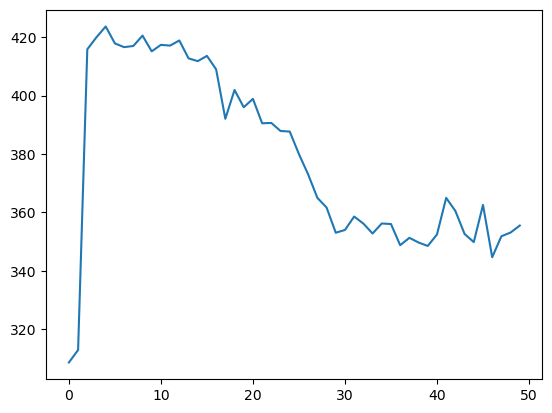

In [14]:
plt.plot(rewards)